<a href="https://colab.research.google.com/github/maverick-0215/Fairness-via-Continual-Learning/blob/main/Testing_EWC_on_permuted_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def train(model, train_loader, criterion, optimizer, device, max_epochs=10, patience=6):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(max_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in train_loader:
            if len(batch)==2:
              inputs,labels=batch
            if len(batch) == 3:
                inputs, labels, _ = batch
            elif len(batch) == 4:
                inputs, labels, _, _ = batch


            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute EWC Loss
            ewc_loss = 0.0
            # for (name, param), (_, old_param) in zip(model.named_parameters(), old_params.items()):
            #     if name in fisher_information:
            #         ewc_loss += (fisher_information[name] * (param - old_param).pow(2)).sum()

            total_loss = loss
            total_loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100 * correct / total

        # Early stopping condition
        if train_loss < best_loss:
            best_loss = train_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return train_loss, train_acc

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[900, 900], output_size=10, dropout_prob=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Function to calculate Fisher Information
def calculate_fisher_information(model, data_loader, criterion, device):
    fisher_information = {}
    model.eval()
    for name, param in model.named_parameters():
        fisher_information[name] = torch.zeros_like(param)

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        for name, param in model.named_parameters():
            fisher_information[name] += param.grad ** 2 / len(data_loader)

    return fisher_information



def train_with_ewc(model, train_loader, criterion, optimizer, fisher_information, old_params, device,
                    ewc_lambda=0.5, max_epochs=100, patience=6):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(max_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in train_loader:
            if len(batch) == 3:
                inputs, labels, _ = batch
            elif len(batch) == 4:
                inputs, labels, _, _ = batch
            else:
                raise ValueError(f"Unexpected batch format: {len(batch)} elements")

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute EWC Loss
            ewc_loss = 0.0
            for (name, param), (_, old_param) in zip(model.named_parameters(), old_params.items()):
                if name in fisher_information:
                    ewc_loss += (fisher_information[name] * (param - old_param).pow(2)).sum()

            total_loss = loss + (ewc_lambda * ewc_loss)
            total_loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100 * correct / total

        # Early stopping condition
        if train_loss < best_loss:
            best_loss = train_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return train_loss, train_acc



# Function to test model
def test_task(model, data_loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    return 100.0 * correct / total

# Function to permute MNIST data
def permute_data(dataset, perm):
    permuted_data = []
    for img, label in dataset:
        img = img.view(-1)[perm].view(1, 28, 28)
        permuted_data.append((img, label))
    return permuted_data

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model, loss, optimizer
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Load Original MNIST
data_transform = transforms.Compose([transforms.ToTensor()])
original_train = datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
original_test = datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)
original_train_loader = torch.utils.data.DataLoader(original_train, batch_size=64, shuffle=True)
original_test_loader = torch.utils.data.DataLoader(original_test, batch_size=64, shuffle=False)

# Train on Original MNIST for 100 epochs
print("\nTraining on Task 0 (Original MNIST)")
for epoch in range(100):
    train_loss_0, train_acc_0 = train(model, original_train_loader, criterion, optimizer, device)


# Test on Original MNIST
test_acc_0 = test_task(model, original_test_loader, device)
print(f"Task 0 - Test Accuracy: {test_acc_0:.2f}%")

# Calculate Fisher Information
fisher_information = calculate_fisher_information(model, original_train_loader, criterion, device)
old_params = {name: param.clone().detach() for name, param in model.named_parameters()}

# Training on Permuted MNIST tasks
num_tasks = 10
original_test_accuracies = []
for task in range(1, num_tasks + 1):
    perm = np.random.permutation(28 * 28)
    permuted_train = permute_data(original_train, perm)
    train_loader = torch.utils.data.DataLoader(permuted_train, batch_size=64, shuffle=True)

    print(f"\nTraining on Task {task} (Permuted MNIST)")
    train_loss, train_acc = train_with_ewc(model, train_loader, criterion, optimizer, fisher_information, old_params, device)
    print(f"Task {task} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    # Test on Original MNIST
    test_acc = test_task(model, original_test_loader, device)
    original_test_accuracies.append(test_acc)
    print(f"Test Accuracy on Original MNIST after Task {task}: {test_acc:.2f}%")

    # Update Fisher Information and Old Parameters
    fisher_information = calculate_fisher_information(model, train_loader, criterion, device)
    old_params = {name: param.clone().detach() for name, param in model.named_parameters()}



Training on Task 0 (Original MNIST)


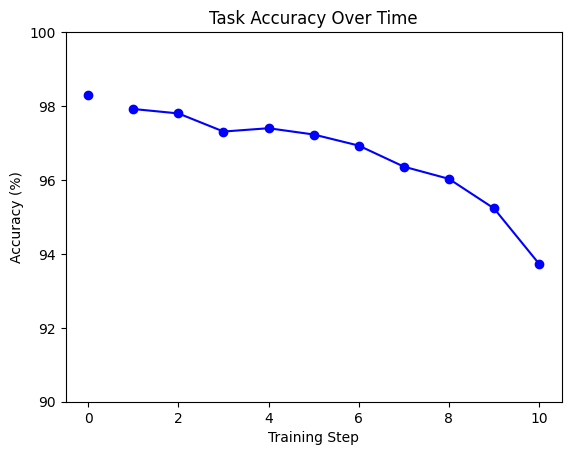

In [ ]:
# Plotting Accuracies+
import matplotlib.pyplot as plt
id=[]
for i in range(1,11):
    id.append(i)
plt.plot(0,test_acc_0, marker='o', linestyle='-', color='b')
plt.plot(id, original_test_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Training Step')
plt.ylabel('Accuracy (%)')
plt.ylim(90,100)
plt.title('Task Accuracy Over Time')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[900, 900], output_size=10, dropout_prob=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Function to calculate Fisher Information
def calculate_fisher_information(model, data_loader, criterion, device):
    fisher_information = {}
    model.eval()
    for name, param in model.named_parameters():
        fisher_information[name] = torch.zeros_like(param)

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        for name, param in model.named_parameters():
            fisher_information[name] += param.grad ** 2 / len(data_loader)

    return fisher_information

def train_with_ewc(model, train_loader, criterion, optimizer, fisher_information, old_params, device,
                    ewc_lambda=0.5, max_epochs=10, patience=6):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(max_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in train_loader:
            if len(batch) == 3:
                inputs, labels, _ = batch
            elif len(batch) == 2:
                inputs, labels = batch
            elif len(batch) == 4:
                inputs, labels, _, _ = batch
            else:
                raise ValueError(f"Unexpected batch format: {len(batch)} elements")

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute EWC Loss
            ewc_loss = 0.0
            for (name, param), (_, old_param) in zip(model.named_parameters(), old_params.items()):
                if name in fisher_information:
                    ewc_loss += (fisher_information[name] * (param - old_param).pow(2)).sum()

            total_loss = loss + (ewc_lambda * ewc_loss)
            total_loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100 * correct / total

        # Early stopping condition
        if train_loss < best_loss:
            best_loss = train_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return train_loss, train_acc

# Function to test model
def test_task(model, data_loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    return 100.0 * correct / total

# Function to permute MNIST data
def permute_data(dataset, perm):
    permuted_data = []
    for img, label in dataset:
        img = img.view(-1)[perm].view(1, 28, 28)
        permuted_data.append((img, label))
    return permuted_data

# Function to flip some images
def flip_images(dataset, flip_probability=0.1):
    flipped_data = []
    for img, label in dataset:
        if np.random.rand() < flip_probability:
            img = transforms.functional.hflip(img)
        flipped_data.append((img, label))
    return flipped_data

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model, loss, optimizer
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Load Original MNIST
data_transform = transforms.Compose([transforms.ToTensor()])
original_train = datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
original_test = datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)
original_train_loader = torch.utils.data.DataLoader(original_train, batch_size=64, shuffle=True)
original_test_loader = torch.utils.data.DataLoader(original_test, batch_size=64, shuffle=False)

# Train on Original MNIST for 100 epochs
print("\nTraining on Task 0 (Original MNIST)")
n=0
for epoch in range(1):
    print(n)
    n+=1
    train_loss_0, train_acc_0 = train(model, original_train_loader, criterion, optimizer, device)


# Test on Original MNIST
test_acc_0 = test_task(model, original_test_loader, device)
print(f"Task 0 - Test Accuracy: {test_acc_0:.2f}%")

# Calculate Fisher Information
fisher_information = calculate_fisher_information(model, original_train_loader, criterion, device)
old_params = {name: param.clone().detach() for name, param in model.named_parameters()}

# Training on Permuted MNIST tasks with flipped images
num_tasks = 10
original_test_accuracies = []
for task in range(1, num_tasks + 1):
    perm = np.random.permutation(28 * 28)
    permuted_train = permute_data(original_train, perm)
    flipped_train = flip_images(permuted_train, flip_probability=0.5)  # Flip 50% of images
    train_loader = torch.utils.data.DataLoader(flipped_train, batch_size=64, shuffle=True)

    print(f"\nTraining on Task {task} (Permuted MNIST with Flipped Images)")
    train_loss, train_acc = train_with_ewc(model, train_loader, criterion, optimizer, fisher_information, old_params, device)
    print(f"Task {task} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    # Test on Original MNIST
    test_acc = test_task(model, original_test_loader, device)
    original_test_accuracies.append(test_acc)
    print(f"Test Accuracy on Original MNIST after Task {task}: {test_acc:.2f}%")

    # Evaluate Equalized Odds (EO) for flipped vs non-flipped
    flipped_correct = 0
    non_flipped_correct = 0
    total_flipped = 0
    total_non_flipped = 0
    for img, label in flipped_train:
        img, label = img.to(device), label.to(device)
        output = model(img.unsqueeze(0))  # Add batch dimension
        _, predicted = output.max(1)

        if np.random.rand() < 0.1:  # This is for checking fairness
            flipped_correct += (predicted == label).sum().item()
            total_flipped += 1
        else:
            non_flipped_correct += (predicted == label).sum().item()
            total_non_flipped += 1

    tpr_flipped = flipped_correct / total_flipped
    tpr_non_flipped = non_flipped_correct / total_non_flipped
    print(f"EO(diff b/w tpr): {(tpr_flipped-tpr_non_flipped):.4f}")

    # Update Fisher Information and Old Parameters
    fisher_information = calculate_fisher_information(model, train_loader, criterion, device)
    old_params = {name: param.clone().detach() for name, param in model.named_parameters()}



Training on Task 0 (Original MNIST)
0
Task 0 - Test Accuracy: 94.60%

Training on Task 1 (Permuted MNIST with Flipped Images)
Task 1 - Train Loss: 0.1982, Train Accuracy: 94.15%
Test Accuracy on Original MNIST after Task 1: 91.42%


AttributeError: 'int' object has no attribute 'to'

In [ ]:
# Plotting Accuracies+
import matplotlib.pyplot as plt
id=[]
for i in range(1,11):
    id.append(i)
plt.plot(0,test_acc_0, marker='o', linestyle='-', color='b')
plt.plot(id, original_test_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Training Step')
plt.ylabel('Accuracy (%)')
plt.ylim(90,100)
plt.title('Task Accuracy Over Time')
plt.show()


NameError: name 'test_acc_0' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Define the neural network (same as before)
class SimpleNN(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[900, 900], output_size=10, dropout_prob=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
# Function to calculate Fisher Information
def calculate_fisher_information(model, data_loader, criterion, device):
    fisher_information = {}
    model.eval()
    for name, param in model.named_parameters():
        fisher_information[name] = torch.zeros_like(param)

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        for name, param in model.named_parameters():
            fisher_information[name] += param.grad ** 2 / len(data_loader)

    return fisher_information

In [ ]:

def train_with_ewc(model, train_loader, criterion, optimizer, fisher_information, old_params, device,
                    ewc_lambda=0.5, max_epochs=10, patience=6):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(max_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in train_loader:
            if len(batch) == 2:
                inputs, labels = batch
            else:
                raise ValueError(f"Unexpected batch format: {len(batch)} elements")

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute EWC Loss
            ewc_loss = 0.0
            for (name, param), (_, old_param) in zip(model.named_parameters(), old_params.items()):
                if name in fisher_information:
                    ewc_loss += (fisher_information[name] * (param - old_param).pow(2)).sum()

            total_loss = loss + (ewc_lambda * ewc_loss)
            total_loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100 * correct / total

        # Early stopping condition
        if train_loss < best_loss:
            best_loss = train_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return train_loss, train_acc

In [ ]:
def test_task(model, data_loader, device):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return 100.0 * correct / total, all_preds, all_targets

def permute_data(dataset, perm):
    permuted_data = []
    for img, label in dataset:
        img = img.view(-1)[perm].view(1, 28, 28)
        permuted_data.append((img, label))
    return permuted_data

def flip_images(dataset, flip_probability=0.5):
    flipped_data = []
    for img, label in dataset:
        is_flipped = np.random.rand() < flip_probability
        if is_flipped:
            img = transforms.functional.hflip(img)
        flipped_data.append((img, label, is_flipped))  # Now includes flip status
    return flipped_data

def calculate_equalized_odds(model, data_loader, device):
    model.eval()
    # For each class (0-9), track TPR for flipped and non-flipped
    class_tpr_flipped = {i: {'correct': 0, 'total': 0} for i in range(10)}
    class_tpr_non_flipped = {i: {'correct': 0, 'total': 0} for i in range(10)}

    with torch.no_grad():
        for batch in data_loader:
            if len(batch) == 3:
                inputs, labels, is_flipped = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)

                for i in range(len(labels)):
                    label = labels[i].item()
                    pred = predicted[i].item()
                    if is_flipped[i]:
                        class_tpr_flipped[label]['total'] += 1
                        if pred == label:
                            class_tpr_flipped[label]['correct'] += 1
                    else:
                        class_tpr_non_flipped[label]['total'] += 1
                        if pred == label:
                            class_tpr_non_flipped[label]['correct'] += 1

    # Calculate EO for each class
    eo_differences = []
    for i in range(10):
        if class_tpr_flipped[i]['total'] > 0 and class_tpr_non_flipped[i]['total'] > 0:
            tpr_flipped = class_tpr_flipped[i]['correct'] / class_tpr_flipped[i]['total']
            tpr_non_flipped = class_tpr_non_flipped[i]['correct'] / class_tpr_non_flipped[i]['total']
            eo_differences.append(abs(tpr_flipped - tpr_non_flipped))

    avg_eo_diff = np.mean(eo_differences) if eo_differences else 0
    return avg_eo_diff

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model, loss, optimizer
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Load Original MNIST
data_transform = transforms.Compose([transforms.ToTensor()])
original_train = datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
original_test = datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)
original_train_loader = torch.utils.data.DataLoader(original_train, batch_size=64, shuffle=True)
original_test_loader = torch.utils.data.DataLoader(original_test, batch_size=64, shuffle=False)

# Train on Original MNIST for 10 epochs
print("\nTraining on Task 0 (Original MNIST)")
for epoch in range(10):
    train_loss_0, train_acc_0 = train_with_ewc(model, original_train_loader, criterion, optimizer,
                                              {}, {}, device)  # No EWC for first task

# Test on Original MNIST
test_acc_0, all_preds, all_targets = test_task(model, original_test_loader, device)
print(f"Task 0 - Test Accuracy: {test_acc_0:.2f}%")

# Calculate confusion matrix for original task
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Original MNIST')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Training on Task 0 (Original MNIST)


KeyboardInterrupt: 


=== Training on Original MNIST (Task 0) ===
Test Accuracy on Original MNIST: 98.13%

=== Training on Flipped Original MNIST (Task 1) ===
Test Accuracy on Original MNIST after Flipped Training: 1.23%
Equalized Odds Difference: 0.0000

=== Final Results ===
Test Accuracies: [98.13, 1.23]
Fairness Metrics: [0]


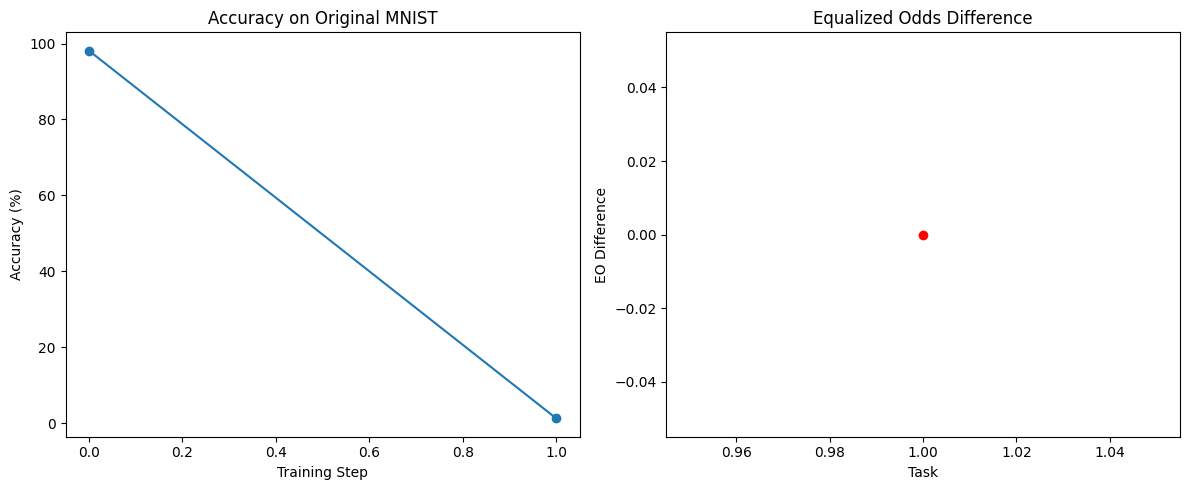

In [ ]:
# Load and prepare data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

test_accuracies = []
fairness_metrics = []

# === Task 0: Original MNIST ===
print("\n=== Training on Original MNIST (Task 0) ===")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

train_loss, train_acc = train_with_ewc(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    fisher_information={},  # No EWC yet
    old_params={},
    device=device,
    ewc_lambda=0,
    max_epochs=10
)

test_acc, _, _ = test_task(model, test_loader, device)
test_accuracies.append(test_acc)
print(f"Test Accuracy on Original MNIST: {test_acc:.2f}%")

# Save Fisher and params for EWC
fisher_information = calculate_fisher_information(model, train_loader, criterion, device)
old_params = {name: param.clone().detach() for name, param in model.named_parameters()}

# === Task 1: Flipped Original MNIST ===
print("\n=== Training on Flipped Original MNIST (Task 1) ===")
flipped_train = flip_images(train_dataset, flip_prob=1.0)
train_loader = torch.utils.data.DataLoader(
    [(x[0], x[1]) for x in flipped_train],
    batch_size=64,
    shuffle=True
)

# Train with EWC
train_loss, train_acc = train_with_ewc(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    fisher_information=fisher_information,
    old_params=old_params,
    device=device,
    ewc_lambda=0.5,
    max_epochs=10,
    patience=3
)

# Test again on original test set
test_acc, _, _ = test_task(model, test_loader, device)
test_accuracies.append(test_acc)
print(f"Test Accuracy on Original MNIST after Flipped Training: {test_acc:.2f}%")

# Fairness: Equalized Odds difference
eo_loader = torch.utils.data.DataLoader(
    flipped_train,
    batch_size=64,
    collate_fn=lambda b: (
        torch.stack([x[0] for x in b]),
        torch.tensor([x[1] for x in b]),
        torch.tensor([x[2] for x in b])  # flipped status
    )
)
eo_diff = calculate_equalized_odds(model, eo_loader, device)
fairness_metrics.append(eo_diff)
print(f"Equalized Odds Difference: {eo_diff:.4f}")

# === Final Evaluation ===
print("\n=== Final Results ===")
print(f"Test Accuracies: {test_accuracies}")
print(f"Fairness Metrics: {fairness_metrics}")

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(test_accuracies)), test_accuracies, marker='o')
plt.title("Accuracy on Original MNIST")
plt.xlabel("Training Step")
plt.ylabel("Accuracy (%)")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(fairness_metrics) + 1), fairness_metrics, marker='o', color='r')
plt.title("Equalized Odds Difference")
plt.xlabel("Task")
plt.ylabel("EO Difference")
plt.tight_layout()
plt.show()
